In [1]:
# CE 295 - Energy Systems and Control
# Final Project: Model Predictive Control and the Optimal Power Flow Problem in the IEEE 39-bus Test Feededr
# Authors (alphabetical): Carla Becker, Hannah Davalos, Jean-Luc Lupien, John Schafer, Keyi Yang
# Adapted from code provided by Prof. Daniel B. Arnold

from cvxpy import *
import data_processing as dp
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd

In [2]:
# Import data for IEEE 39-bus Test Feeder (plus 8 battery nodes)

# Define transformer resistance and reactance (not provided by test feeder)
xformer_r = 0.0001
xformer_x = 0.0015

# Adjacency matrix; assumes power can flow in two directions on all lines
A_df = pd.read_excel('IEEE 39 Test Bus Data/IEEE_39_bus_data.xlsx', sheet_name='A matrix')
A_df = A_df.iloc[:,1:] # remove the column labels
A    = A_df.values     # convert to a numpy array

# Resistance matrix
r_df = pd.read_excel('IEEE 39 Test Bus Data/IEEE_39_bus_data.xlsx', sheet_name='r matrix')
r_df = r_df.iloc[:,1:] # remove the column labels
r    = r_df.values     # convert to a numpy array

# Reactance matrix
x_df = pd.read_excel('IEEE 39 Test Bus Data/IEEE_39_bus_data.xlsx', sheet_name='x matrix')
x_df = x_df.iloc[:,1:] # remove the column labels
x    = x_df.values     # convert to a numpy array

# Get parents vector (matrix??)
rho_df = pd.read_excel('IEEE 39 Test Bus Data/IEEE_39_bus_data.xlsx', sheet_name='rho')
rho_df = rho_df.iloc[:,1:] # remove the column labels
rho    = rho_df.values.squeeze()

# Number of nodes
num_nodes = A.shape[0]

# Diesel nodes
diesel_nodes = np.array([0])
max_diesel_power = 10 # TODO set sensible value
diesel_cost = 100 # TODO set sensible value

# Battery energy storage nodes
BESS_nodes = np.array([28, 29, 30, 31, 44, 45, 46])
max_battery_power = 10 # TODO set sensible value
battery_cost = 0

# Wind nodes
wind_nodes = np.array([40, 41, 42])
max_wind_power = 10 # TODO set sensible value
wind_cost = 0

# Solar nodes
solar_nodes = np.array([24, 25, 26, 27])
max_solar_power = 10 # TODO set sensible value
solar_cost = 0

# Consumer nodes
consumer_nodes = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 43])

In [3]:
# Read in daily generation and load data
pv_directory   = 'PV Generation Data'
load_directory = 'Building Load Data'
wind_directory = 'Wind Generation Data'

# ALREADY GENERATED, takes 5 minutes to generate again so keep commented out
#dp.generate_json_from_pv_data(pv_directory) 
#dp.generate_json_from_bldg_data(load_directory) 
#dp.generate_json_from_wind_data(wind_directory) 

with open(os.path.join(pv_directory, 'pv_data.json'), 'r') as json_file:
    pv_dict = json.load(json_file)

for key in pv_dict.keys(): # get data from first key only (CAPTL_WF)
    solar_data = np.array(pv_dict[key])
    break

# for key, value in pv_dict.items():
    # print(key, value['0'])
    # break

with open(os.path.join(load_directory, 'real_data.json'), 'r') as json_file:
    real_load_dict = json.load(json_file)

with open(os.path.join(load_directory, 'reactive_data.json'), 'r') as json_file:
    reactive_load_dict = json.load(json_file)

with open(os.path.join(wind_directory, 'wind_data.json'), 'r') as json_file:
    wind_dict = json.load(json_file)

# There are 67 PV panels
# There are 27 buildings
# There are 22 wind turbines

# There are 427 days of data for each entity
# Each data has 96 data points: one measurement every 15 minutes

Text(0.5, 1.0, 'February 26, 2020')

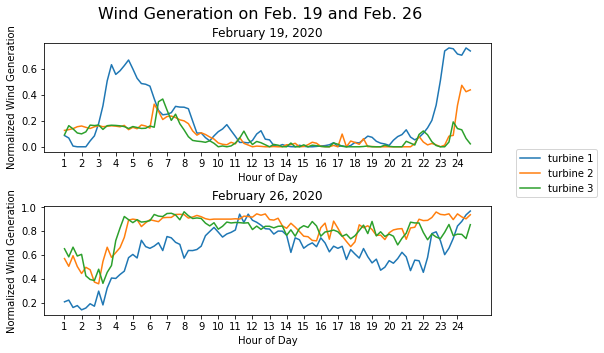

In [32]:
# Define target days
feb19 = '411' 
feb26 = '423' 

# Wind Data
fig1, ax1 = plt.subplots(2, figsize=(8, 5))
for t, turbine in enumerate(wind_dict):
    turbine_label = f'turbine {t+1}'
    if t < 3:
        for day in wind_dict[turbine]:
            if day == feb19:
                ax1[0].plot(range(96), wind_dict[turbine][day], label=turbine_label)
            if day == feb26:
                ax1[1].plot(range(96), wind_dict[turbine][day], label=turbine_label)

# Plot Labels
plt.suptitle('Wind Generation on Feb. 19 and Feb. 26', fontsize=16)
plt.subplots_adjust(hspace=0.5) 
plt.legend(loc='center right', bbox_to_anchor=(1.25, 1.3))

ax1[0].set_xlabel('Hour of Day')
ax1[0].set_xticks(range(0,96,4), range(1,25))
ax1[0].set_ylabel('Normalized Wind Generation')
ax1[0].set_title('February 19, 2020')

ax1[1].set_xlabel('Hour of Day')
ax1[1].set_xticks(range(0,96,4), range(1,25))
ax1[1].set_ylabel('Normalized Wind Generation')
ax1[1].set_title('February 26, 2020')

Text(0.5, 1.0, 'February 26, 2020')

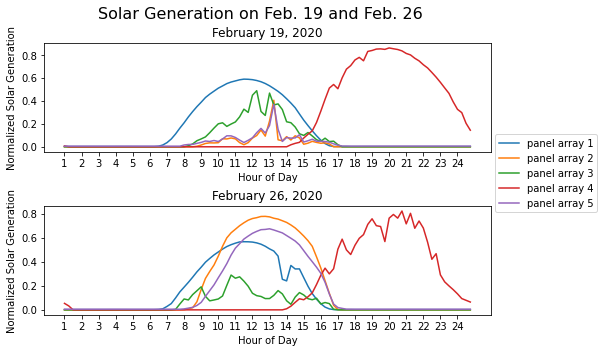

In [33]:
# Solar Data
fig2, ax2 = plt.subplots(2, figsize=(8, 5))
for p, panel in enumerate(pv_dict):
    panel_label = f'panel array {p+1}'
    if p < 5:
        for day in pv_dict[panel]:
            if day == feb19:
                ax2[0].plot(range(96), pv_dict[panel][day], label=panel_label)
            if day == feb26:
                ax2[1].plot(range(96), pv_dict[panel][day], label=panel_label)

# Plot Labels
plt.suptitle('Solar Generation on Feb. 19 and Feb. 26', fontsize=16)
plt.subplots_adjust(hspace=0.5) 
plt.legend(loc='center right', bbox_to_anchor=(1.25, 1.3))

ax2[0].set_xlabel('Hour of Day')
ax2[0].set_xticks(range(0,96,4), range(1,25))
ax2[0].set_ylabel('Normalized Solar Generation')
ax2[0].set_title('February 19, 2020')

ax2[1].set_xlabel('Hour of Day')
ax2[1].set_xticks(range(0,96,4), range(1,25))
ax2[1].set_ylabel('Normalized Solar Generation')
ax2[1].set_title('February 26, 2020')

Text(0.5, 1.0, 'February 26, 2020')

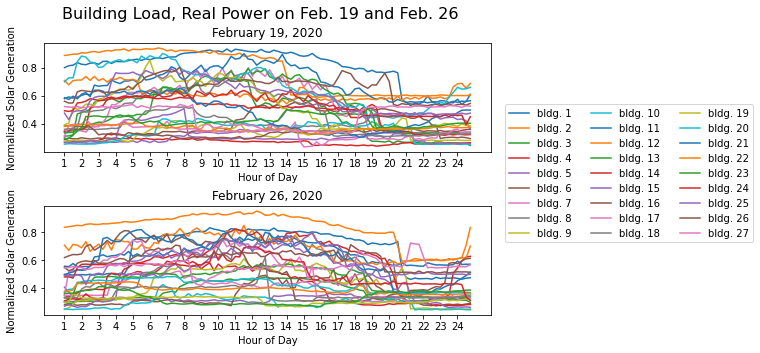

In [38]:
# Building Load Data
fig3, ax3 = plt.subplots(2, figsize=(8, 5))
for b, bldg in enumerate(real_load_dict):
    bldg_label = f'bldg. {b+1}'
    for day in real_load_dict[bldg]:
        if day == feb19:
            ax3[0].plot(range(96), real_load_dict[bldg][day], label=bldg_label)
        if day == feb26:
            ax3[1].plot(range(96), real_load_dict[bldg][day], label=bldg_label)

# Plot Labels
plt.suptitle('Building Load, Real Power on Feb. 19 and Feb. 26', fontsize=16)
plt.subplots_adjust(hspace=0.5) 
plt.legend(loc='center right', bbox_to_anchor=(1.6, 1.3), ncol=3)

ax3[0].set_xlabel('Hour of Day')
ax3[0].set_xticks(range(0,96,4), range(1,25))
ax3[0].set_ylabel('Normalized Solar Generation')
ax3[0].set_title('February 19, 2020')

ax3[1].set_xlabel('Hour of Day')
ax3[1].set_xticks(range(0,96,4), range(1,25))
ax3[1].set_ylabel('Normalized Solar Generation')
ax3[1].set_title('February 26, 2020')

In [11]:
# Get mean and std for each time period for solar power

TimeValues_Solar = []
numDays = 427
numTimes = 96
Means_Solar = []
StDevs_Solar = []

for time in range(numTimes):
    TimeValues_Solar.append([])

# print(TimeValues)

for key, value in pv_dict.items():
    for day in range(numDays):
        for time in range(numTimes):
            TimeValues_Solar[time].append(value[str(day)][time])

for timeList in TimeValues_Solar:
    Means_Solar.append(np.mean(timeList))
    StDevs_Solar.append(np.std(timeList))
    

# print(len(TimeValues[1]))
print(len(Means_Solar))
print(len(StDevs_Solar))

96
96


In [11]:
# Get mean and std for each time period for wind power

TimeValues_Wind = []
numDays = 427
numTimes = 96
Means_Wind = []
StDevs_Wind = []

for time in range(numTimes):
    TimeValues_Wind.append([])

# print(TimeValues)

for key, value in wind_dict.items():
    for day in range(numDays):
        for time in range(numTimes):
            TimeValues_Wind[time].append(value[str(day)][time])

for timeList in TimeValues_Wind:
    Means_Wind.append(np.mean(timeList))
    StDevs_Wind.append(np.std(timeList))

# print(TimeValues_Wind)

# print(len(TimeValues_Wind[0]))

print(len(Means_Wind))
print(len(StDevs_Wind))

96
96


In [12]:
## 39 Node IEEE Test Feeder Parameters

### Node (aka Bus) Data
# l_j^P: Active power consumption [MW]
cons_real_power = real_load_dict

# l_j^Q: Reactive power consumption [MVAr]
cons_reactive_power = reactive_load_dict

# s_j,max: Maximal generating power [MW]
max_apparent_power = np.zeros(num_nodes)
max_apparent_power[diesel_nodes] = max_diesel_power
max_apparent_power[BESS_nodes]   = max_battery_power
max_apparent_power[wind_nodes]   = max_wind_power
max_apparent_power[solar_nodes]  = max_solar_power
max_apparent_power = max_apparent_power.reshape(1, num_nodes)

# c_j: Marginal generation cost [USD/MW]
c = np.zeros(num_nodes)
c[diesel_nodes] = diesel_cost
c[BESS_nodes]   = battery_cost
c[wind_nodes]   = wind_cost
c[solar_nodes]  = solar_cost
c = c.reshape(num_nodes, 1)

# V_min, V_max: Minimum and maximum nodal voltages [V]
min_voltage = 0.95
max_voltage = 1.05

# I_max_ij: Maximal line current [p.u.]
I_max = A * 0.01

### Set Data
# List of node indices
j_idx = np.arange(num_nodes) # TODO necessary?

In [13]:
# Organize consumed real and reactive power into numpy arrays
# Only load ** 1 ** day of data (horizon is 1 day, 96 points)
num_bldgs = len(real_load_dict.keys())
real_power_consumed     = np.zeros((len(consumer_nodes), 96))
reactive_power_consumed = np.zeros((len(consumer_nodes), 96))

# For first 27 consumer nodes (only 27 buildings)
for node in range(num_bldgs):
    for b, bldg in enumerate(real_load_dict.keys()):
        if node % num_bldgs == b:
            real_power_consumed[node, :]     = real_load_dict[bldg]['0'] # ['0'] because only 1 day
            reactive_power_consumed[node, :] = reactive_load_dict[bldg]['0']

# For remaining consumer nodes, repeat some of the buildings
for node in range(num_bldgs, len(consumer_nodes)):
    for b, bldg in enumerate(real_load_dict.keys()):
        if node % num_bldgs == b:
            real_power_consumed[node, :]     = real_load_dict[bldg]['0']
            reactive_power_consumed[node, :] = reactive_load_dict[bldg]['0']

# Now, only load these values into the consumer nodes, have zeros for all other nodes
cons_real_power     = np.zeros((num_nodes, 96))
cons_reactive_power = np.zeros((num_nodes, 96))

cons_real_power[consumer_nodes, :]     = real_power_consumed
cons_reactive_power[consumer_nodes, :] = reactive_power_consumed

In [24]:
def cvx_optim(cons_real_power, cons_reactive_power, max_apparent_power, min_voltage, max_voltage, BESS_nodes, wind_nodes, solar_nodes, diesel_nodes):

    num_nodes = cons_real_power.shape[0]
    horizon   = cons_real_power.shape[1]
    renew_nodes = np.concatenate([wind_nodes, solar_nodes])
    
    # Define optimization variables for generated power
    gen_real_power       = Variable((num_nodes, horizon))
    gen_reactive_power   = Variable((num_nodes, horizon))
    gen_apparent_power   = Variable((num_nodes, horizon))

    # Define optimization variables for active line power
    # index 0 is the time step, index 1 is node 1, index 2 is node 2
    line_real_power      = [Variable((num_nodes, num_nodes)) for t in range(horizon)] 
    line_reactive_power  = [Variable((num_nodes, num_nodes)) for t in range(horizon)]
    line_complex_current = [Variable((num_nodes, num_nodes)) for t in range(horizon)]

    # Line voltage decision variable
    line_voltages = Variable((num_nodes, horizon))
    
    # Decision variable for robust optimization
    # TODO read from PV and wind data instead ??
    # sigma_A = Variable((len(renew_nodes), horizon)) 

    # TODO see if it works this way to include wind and solar separately
    # Decision variables for robust optimization
    sigma_A_solar = Variable((len(solar_nodes), horizon))
    sigma_A_wind = Variable((len(wind_nodes), horizon))

    '''
    TODO properly integrate BESS
    # Define optimization variables for battery energy storage system (BESS)
    BESS_energy          = Variable((num_nodes, horizon))
    BESS_chrg_dis        = Variable((num_nodes, horizon))

    # BESS Parameters
    timestep=.25 # assuming 15min timestep
    eta=.95 #(charging /discharging efficiency)
    energy_min=0 #minimun energy level of BESS, need to define for every node seperately?
    #100 max energy level of BESS, in kWh NEED TO SCALE
    energy_max=np.array([0, 0, 0,0, 100, 100, 0, 0, 0, 0, 0]) #placeholder, need actual nodes that have BESS, needs to have 39 nodes
    
    ramp_max= 100 / timestep #1C, can discharge/charge 1 full capacity every hour, assuming timestep is in hours
    #initial_energy=np.zeros(BESS_nodes) #place holder
    #where to I specify which nodes are BESS?

    # BESS initial state
    #constraints = [BESS_energy[:, 0] == initial_energy]  # initial_energy needs to be defined
    '''

    # Define objective function
    objective =  Minimize(sum(sum(c.T @ gen_apparent_power)))

    # Define constraints
    # Apparent Power Limits
    constraints = [gen_apparent_power[:, t] <= np.squeeze(max_apparent_power) for t in range(horizon)]

    # Constants for robust optimization constants
    # TODO see if we want to change these to those within the for loop
    a = np.array([-1.25, 1])
    bar_a = np.tile(a, len(renew_nodes))

    e_array = np.array((0.25, 0))
    E = np.diag(np.tile(e_array, len(renew_nodes)))

    # Loop over every time step in the horizon, loop over each nodes in each time step
    for t in range(horizon):

        #print(f't: {t}')
    
        # TODO included robust optimization constr for solar and wind
        a_solar = np.array([-1*(Means_Solar[t] + StDevs_Solar[t]), 1])
        bar_a_solar = np.tile(a_solar, len(solar_nodes))

        e_array_solar = np.array((StDevs_Solar[t], 0))
        E_solar = np.diag(np.tile(e_array_solar, len(solar_nodes)))

        a_wind = np.array([-1*(Means_Wind[t] + StDevs_Wind[t]), 1])
        bar_a_wind = np.tile(a_wind, len(wind_nodes))

        e_array_wind = np.array([StDevs_Wind[t], 0])
        E_wind = np.diag(np.tile(e_array_wind, len(wind_nodes)))

        # Define robust optimization decision variables for intermittent energy sources
        y_solar = vstack([sigma_A_solar[0, t], gen_apparent_power[solar_nodes[0]][t]])
        for i in range(1, len(solar_nodes)):
            y_solar = vstack([y_solar, vstack([sigma_A_solar[i, t], gen_apparent_power[solar_nodes[i]][t]])])

        y_wind = vstack([sigma_A_wind[0, t], gen_apparent_power[wind_nodes[0]][t]])
        for i in range(1, len(wind_nodes)):
            y_wind = vstack([y_wind, vstack([sigma_A_wind[i, t], gen_apparent_power[wind_nodes[i]][t]])])

        # Robust Optimization Constraints
        constraints += [bar_a_solar @ y_solar + norm(E_solar @ y_solar) <= 0]
        constraints += [sigma_A_solar[:, t] >= 0, sigma_A_solar[:, t] <= 1]

        constraints += [bar_a_wind @ y_wind + norm(E_wind @ y_wind) <= 0]
        constraints += [sigma_A_wind[:, t] >= 0, sigma_A_wind[:, t] <= 1]

        # Diesel node constraints
        for node in diesel_nodes:
            diesel_node = int(node)

            # Boundary condition for power line flows
            constraints += [line_real_power[t][diesel_node][diesel_node] == 0]
            constraints += [line_reactive_power[t][diesel_node][diesel_node] == 0]

            # Boundary condition for squared line current
            constraints += [line_complex_current[t][diesel_node][diesel_node] == 0]

            # Fix diesel node voltage to be 1 "per unit" (p.u.)
            constraints += [line_voltages[diesel_node][t] == 1]

        for jj in j_idx: 
            
            '''
            TODO properly integrate BESS
            #BESS static Constraints
            constraints +=[energy_min<=BESS_energy[jj, t], BESS_energy[jj, t] <= energy_max[jj]] #every battery node has energy limits for every time

            if t < horizon - 1:
                # Ramp rate constraints
                constraints += [BESS_chrg_dis[jj, t + 1] - BESS_chrg_dis[jj, t] <= ramp_max,
                                BESS_chrg_dis[jj, t] - BESS_chrg_dis[jj, t + 1] <= ramp_max]

                # BESS energy dynamics
                constraints += [BESS_energy[jj, t + 1] == BESS_energy[jj, t] + timestep * eta * BESS_chrg_dis[jj, t]]
            '''

            # Nodal voltage limits, not dependent on t
            constraints += [min_voltage**2 <= line_voltages[jj,t]]
            constraints += [line_voltages[jj,t] <= max_voltage**2]

            # Non-negative power generation
            constraints += [gen_real_power[jj, t] >= 0]
            constraints += [gen_reactive_power[jj, t] >= 0]

            # Parent node, i = rho(j)
            ii = rho[jj] # TODO change to work for multiple parents, see the variable future_rho
            print(f't, jj, ii: {t}, {ii}, {jj}')

            # Squared line current limits
            constraints += [line_complex_current[t][ii][jj] <= (I_max[ii][jj])**2] 

            # Line Power Flows
            #Is there a typo here? Should it be based on cons_reactive_power AND cons_real_power?
            constraints += [line_real_power[t][ii][jj]     == (cons_reactive_power[jj][t] - gen_apparent_power[jj][t]) + r[ii][jj]*line_complex_current[t][ii][jj] + A[jj]@line_real_power[jj].T]
            constraints += [line_reactive_power[t][ii][jj] == (cons_reactive_power[jj][t] - gen_apparent_power[jj][t]) + x[ii][jj]*line_complex_current[t][ii][jj] + A[jj]@line_real_power[jj].T]

            # Nodal voltage
            constraints += [line_voltages[jj][t] == line_voltages[ii][t] + ((r[ii][jj])**2 + (x[ii][jj])**2)*line_complex_current[ii][jj] - 2*(r[ii][jj]*line_real_power[ii][jj]+x[ii][jj]*line_reactive_power[ii][jj])]
            
            # Squared current magnitude on lines
            constraints += [line_complex_current[t][ii][jj] >= quad_over_lin(vstack([line_real_power[t][ii][jj], line_reactive_power[t][ii][jj]]), line_voltages[jj][t])]

            # Compute apparent power from active & reactive power
            constraints += [norm(vstack([gen_real_power[jj][t], gen_reactive_power[jj][t]])) <= gen_apparent_power[jj][t]]

    # Define problem and solve
    prob = Problem(objective, constraints)
    prob.solve()

    # Output Results
    print(prob.status)
    print(f"Minimum Generating Cost: {prob.value} USD")

    print(" ")
    print(f"Node 30 [Diesel]: real power = {gen_real_power[30].value} MW | reactive power = {gen_reactive_power[30].value} MVAr | apparent power = {gen_apparent_power[30].value} MVA")
    
    print(" ")
    for node in renew_nodes:
        print(f"Node {node} [Renewable]: real power = {gen_real_power[node].value} MW | reactive power = {gen_reactive_power[node].value} MVAr | apparent power = {gen_apparent_power[node].value} MVA")
    
    print(" ")
    #print(f"Total active real power:     {np.sum(line_real_power)} MW consumed | {np.sum(gen_real_power)} MW generated")
    #print(f"Total active reactive power: {np.sum(line_reactive_power)} MW consumed | {np.sum(gen_reactive_power)} MW generated")
    

In [25]:
# Test csv_optim function
cvx_optim(cons_real_power, cons_reactive_power, max_apparent_power, min_voltage, max_voltage, BESS_nodes, wind_nodes, solar_nodes, diesel_nodes)

t, jj, ii: 0, 0, 0
t, jj, ii: 0, 0, 1
t, jj, ii: 0, 0, 2
t, jj, ii: 0, 0, 3
t, jj, ii: 0, 1, 4
t, jj, ii: 0, 1, 5
t, jj, ii: 0, 1, 6
t, jj, ii: 0, 1, 7
t, jj, ii: 0, 4, 8
t, jj, ii: 0, 5, 9
t, jj, ii: 0, 6, 10
t, jj, ii: 0, 7, 11
t, jj, ii: 0, 8, 12
t, jj, ii: 0, 9, 13
t, jj, ii: 0, 10, 14
t, jj, ii: 0, 11, 15
t, jj, ii: 0, 2, 16
t, jj, ii: 0, 2, 17
t, jj, ii: 0, 2, 18
t, jj, ii: 0, 2, 19
t, jj, ii: 0, 16, 20
t, jj, ii: 0, 17, 21
t, jj, ii: 0, 18, 22
t, jj, ii: 0, 19, 23
t, jj, ii: 0, 20, 24
t, jj, ii: 0, 21, 25
t, jj, ii: 0, 22, 26
t, jj, ii: 0, 23, 27
t, jj, ii: 0, 24, 28
t, jj, ii: 0, 25, 29
t, jj, ii: 0, 26, 30
t, jj, ii: 0, 27, 31
t, jj, ii: 0, 3, 32
t, jj, ii: 0, 3, 33
t, jj, ii: 0, 3, 34
t, jj, ii: 0, 3, 35
t, jj, ii: 0, 32, 36
t, jj, ii: 0, 33, 37
t, jj, ii: 0, 34, 38
t, jj, ii: 0, 35, 39
t, jj, ii: 0, 36, 40
t, jj, ii: 0, 37, 41
t, jj, ii: 0, 38, 42
t, jj, ii: 0, 39, 43
t, jj, ii: 0, 40, 44
t, jj, ii: 0, 41, 45
t, jj, ii: 0, 42, 46
t, jj, ii: 1, 0, 0
t, jj, ii: 1, 0, 1
t, jj, 

/Users/carlabecker/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
#No Reactive Power Test
def cvx_optim_real_power(cons_real_power, max_power, min_voltage, max_voltage, BESS_nodes, wind_nodes, solar_nodes, diesel_nodes):

    num_nodes = cons_real_power.shape[0]
    horizon   = cons_real_power.shape[1]
    renew_nodes = np.concatenate([wind_nodes, solar_nodes])
    
    # Define optimization variables for generated power
    gen_real_power       = Variable((num_nodes, horizon))
    #gen_reactive_power   = Variable((num_nodes, horizon))
    #gen_apparent_power   = Variable((num_nodes, horizon))

    # Define optimization variables for active line power
    # index 0 is the time step, index 1 is node 1, index 2 is node 2
    line_real_power      = [Variable((num_nodes, num_nodes)) for t in range(horizon)] 
    #line_reactive_power  = [Variable((num_nodes, num_nodes)) for t in range(horizon)]

    #Line Complex current Subbed for Line_current
    line_current = [Variable((num_nodes, num_nodes)) for t in range(horizon)] 

    # Line voltage decision variable
    line_voltages = Variable((num_nodes, horizon))
    
    # Decision variable for robust optimization
    # TODO read from PV and wind data instead ??
    sigma_A = Variable((len(renew_nodes), horizon)) 

    # Define optimization variables for battery energy storage system (BESS)
    BESS_energy          = Variable((num_nodes, horizon))
    BESS_chrg_dis        = Variable((num_nodes, horizon))

    # BESS Parameters
    timestep=.25 # assuming 15min timestep
    eta=.95 #(charging /discharging efficiency)
    energy_min=0 #minimun energy level of BESS, need to define for every node seperately?
    #100 max energy level of BESS, in kWh NEED TO SCALE
    energy_max=np.array([0, 0, 0,0, 100, 100, 0, 0, 0, 0, 0]) #placeholder, need actual nodes that have BESS, needs to have 39 nodes
    ramp_max= 100 / timestep #1C, can discharge/charge 1 full capacity every hour, assuming timestep is in hours
    initial_energy=.5*np.ones(BESS_nodes) #place holder
    # BESS initial state
    constraints = [BESS_energy[:, 0] == initial_energy]  # initial_energy needs to be defined


    # Define objective function
    objective =  Minimize(sum(sum(c.T @ gen_real_power )))

    # Define constraints
    # Power Limits: max_apparent_power=max_real_power
    constraints = [gen_real_power[:, t] <= np.squeeze(max_power) for t in range(horizon)]

    # Constants for robust optimization constants
    a = np.array([-1.25, 1])
    bar_a = np.tile(a, len(renew_nodes))

    e_array = np.array((0.25, 0))
    E = np.diag(np.tile(e_array, len(renew_nodes)))

    # Loop over every time step in the horizon, loop over each nodes in each time step
    for t in range(horizon):

        # Define robust optimization decision variables for intermittent energy sources
        y = vstack([sigma_A[0, t], gen_real_power[renew_nodes[0]][t]])
        for i in range(1, len(renew_nodes)):
            y = vstack([y, vstack([sigma_A[i, t], gen_real_power[renew_nodes[i]][t]])])

        # Robust Optimization Constraints
        constraints += [bar_a @ y + norm(E @ y) <= 0]
        constraints += [sigma_A[:, t] >= 0, sigma_A[:, t] <= 1]

        # Diesel node constraints
        for node in diesel_nodes:
            diesel_node = int(node)

            #NEED TO DEFINE BOUNDRY CONDITION EARLIER????

            # Boundary condition for power line flows
            constraints += [line_real_power[t][diesel_node][diesel_node] == 0]
            #constraints += [line_reactive_power[t][diesel_node][diesel_node] == 0]

            # Boundary condition for squared line current
            constraints += [line_current[t][diesel_node][diesel_node] == 0]

            # Fix diesel node voltage to be 1 "per unit" (p.u.)
            constraints += [line_voltages[diesel_node][t] == 1]
        for node in BESS_nodes:
            bess_node=int(node)
            #BESS static Constraints
            constraints +=[energy_min<=BESS_energy[bess_node, t], BESS_energy[bess_node, t] <= energy_max[bess_node]] #every battery node has energy limits for every time

            if t < horizon - 1:
                # Ramp rate constraints
                constraints += [BESS_chrg_dis[bess_node][t + 1] - BESS_chrg_dis[bess_node][t] <= ramp_max,
                                BESS_chrg_dis[bess_node][t] - BESS_chrg_dis[bess_node][t + 1] <= ramp_max]
                # BESS energy dynamics
                constraints += [BESS_energy[bess_node][t + 1] == BESS_energy[bess_node][t] + timestep * eta * BESS_chrg_dis[bess_node][t]]

        for jj in j_idx: # TODO test for more nodes j_idx
            # Nodal voltage limits, not dependent on t
            constraints += [min_voltage**2 <= line_voltages[jj,t]]
            constraints += [line_voltages[jj,t] <= max_voltage**2]

            # Non-negative power generation
            constraints += [gen_real_power[jj, t] >= 0]
            #constraints += [gen_reactive_power[jj, t] >= 0]

            # Parent node, i = rho(j)
            ii = rho[jj] # TODO change to work for multiple parents, see the variable future_rho

            # Squared line current limits
            constraints += [line_current[t][ii][jj] <= (I_max[ii][jj])**2] 

            # Line Power Flows
            #constraints += [line_real_power[t][ii][jj]     == (cons_reactive_power[jj][t] - gen_apparent_power[jj][t]) + r[ii][jj]*line_complex_current[t][ii][jj] + A[jj]@line_real_power[jj].T]
            #constraints += [line_reactive_power[t][ii][jj] == (cons_reactive_power[jj][t] - gen_apparent_power[jj][t]) + x[ii][jj]*line_complex_current[t][ii][jj] + A[jj]@line_real_power[jj].T]
            #WHat does the term A[jj]@line_real_power[jj].T do??
            constraints += [line_real_power[t][ii][jj] == cons_real_power[jj][t] - gen_real_power[jj][t] - r[ii][jj] * line_real_power[t][ii][jj]+ A[jj]@line_real_power[jj].T]


            # Nodal voltage
            #constraints += [line_voltages[jj][t] == line_voltages[ii][t] + ((r[ii][jj])**2 + (x[ii][jj])**2)*line_complex_current[ii][jj] - 2*(r[ii][jj]*line_real_power[ii][jj]+x[ii][jj]*line_reactive_power[ii][jj])]
            constraints += [line_voltages[jj][t] == line_voltages[ii][t] - r[ii][jj] * line_real_power[ii][jj]]
            
            # Squared current magnitude on lines
            # I^2= (P^2 +Q^2)/ V^2 is original formula , I^2=(P^2)/ V^2 = I= P/V
            #constraints += [line_complex_current[t][ii][jj] >= quad_over_lin(vstack([line_real_power[t][ii][jj], line_reactive_power[t][ii][jj]]), line_voltages[jj][t])]
            constraints += [line_current[t][ii][jj] >= quad_over_lin(line_real_power[t][ii][jj], line_voltages[jj][t])]

            # Compute apparent power from active & reactive power
            #constraints += [norm(vstack([gen_real_power[jj][t], gen_reactive_power[jj][t]])) <= gen_apparent_power[jj][t]]

    # Define problem and solve
    prob = Problem(objective, constraints)
    prob.solve()

    # Output Results
    print(prob.status)
    print(f"Minimum Generating Cost: {prob.value} USD")

    print(" ")
    print(f"Node 30 [Diesel]: real power = {gen_real_power[30].value} MW")
    
    print(" ")
    for node in renew_nodes:
        print(f"Node {node} [Renewable]: real power = {gen_real_power[node].value} MW")
    
    print(" ")
    #print(f"Total active real power:     {np.sum(line_real_power)} MW consumed | {np.sum(gen_real_power)} MW generated")
    #print(f"Total active reactive power: {np.sum(line_reactive_power)} MW consumed | {np.sum(gen_reactive_power)} MW generated")
    